✅ GPU memory growth enabled
Total available pairs: 58620
Using 16000 train and 4000 val samples (total 20000)
Steps per epoch: 4000 Validation steps: 1000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None,

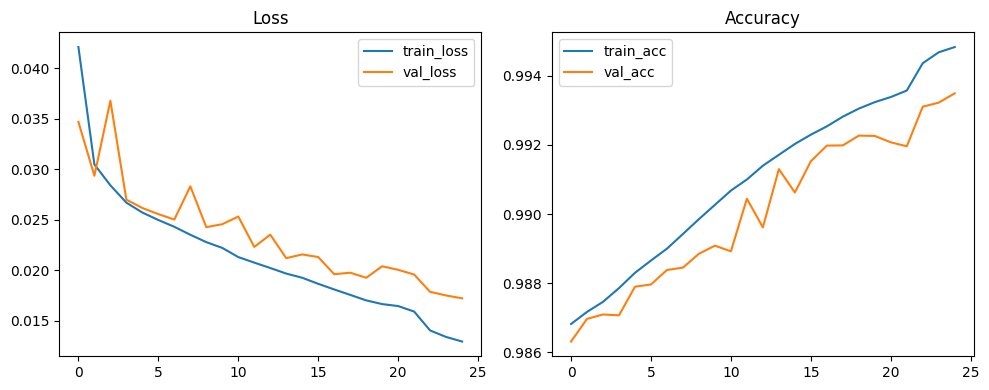


Showing 4 sample predictions from validation set...


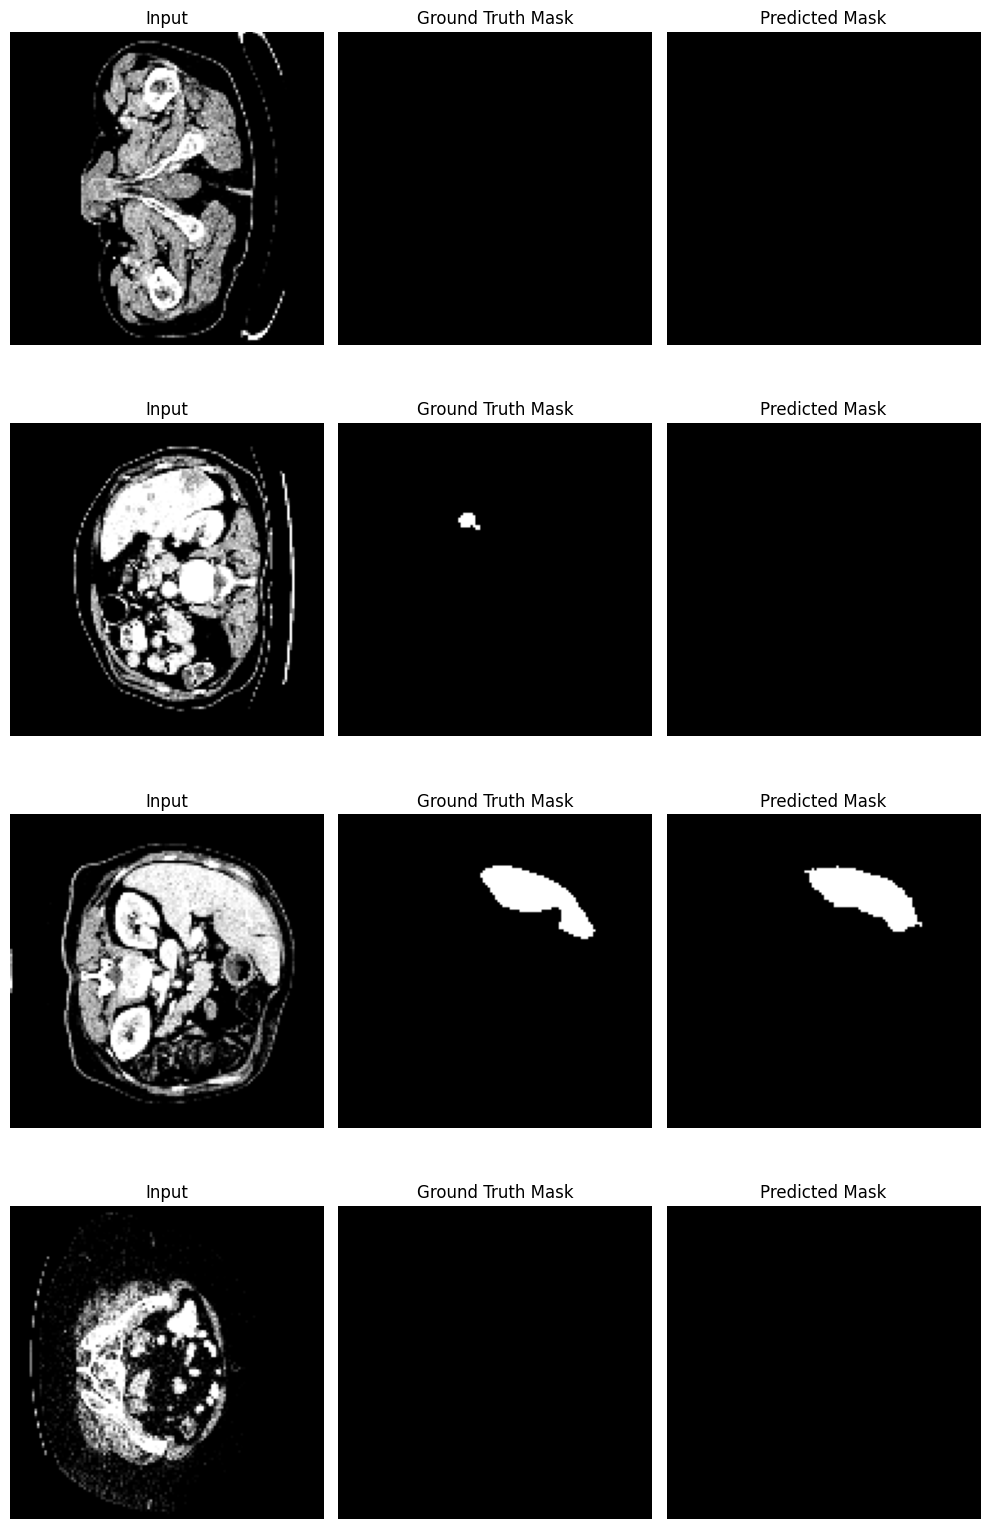


✅ Training & evaluation complete. Best checkpoint (if saved) is at: best_unet_checkpoint.h5


In [1]:


import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, jaccard_score


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)        # model input size
NUM_SAMPLES = 20000          # use only 20k pairs
BATCH_SIZE = 4               # reduce if OOM
EPOCHS = 25
CHECKPOINT_PATH = "best_unet_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4


gpus = tf.config.experimental.list_th (physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠️ GPU memory growth setup failed:", e)
else:
    print("⚠️ No GPU found, training on CPU")

# ----------------------------
# Helper: list & sample indices
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    print(f"Total available pairs: {total}")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()  # sorting gives stable file ordering within the chosen set (optional)
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Split chosen indices into train/val
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Using {len(train_indices)} train and {len(val_indices)} val samples (total {num_chosen})")

# ----------------------------
# Data generator (yields batches of (images, masks))
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)  # shape (H,W,1)

def mask_to_binary(mask_arr):
    # Input mask arr in [0..1] float — convert to binary 0/1
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    # skip problematic files
                    print("Skipping file due to error:", e)
                    continue
                Xb.append(img)
                # ensure mask is binary 0/1
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            Xb = np.stack(Xb, axis=0).astype(np.float32)
            Yb = np.stack(Yb, axis=0).astype(np.float32)
            yield Xb, Yb

# Create python generators
train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# UNet model (same architecture you provided)
# ----------------------------
def unet_model(input_size=(128,128,1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(p3)
    c4 = layers.Dropout(0.3)(c4)
    c4 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c5)

    u6 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(c7)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(c7)
    return models.Model(inputs=[inputs], outputs=[outputs])

model = unet_model(input_size=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1)
cb_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
cb_earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# ----------------------------
# Train model (generator-based)
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop],
    verbose=1
)

# ----------------------------
# Helper metrics: Dice & IoU (numpy)
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# ----------------------------
# Evaluate on full validation set (streaming)
# ----------------------------
print("\n🔍 Running evaluation on validation set (streaming predictions)...")
y_trues = []
y_preds_probs = []

# create an iterator over val_gen but without infinite loop — we know validation_steps
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)
batches_done = 0
while batches_done < validation_steps:
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb)  # shape (batch, H, W, 1)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    batches_done += 1

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

# ensure same length (sometimes last batch smaller)
n_val = min(y_trues.shape[0], y_preds_probs.shape[0])
y_trues = y_trues[:n_val]
y_preds_probs = y_preds_probs[:n_val]

# Flatten arrays for some metrics
y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Compute metrics
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)

# roc_auc_score requires at least one positive and one negative in y_true_flat
try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except ValueError:
    auc = float('nan')

# Dice & IoU per-image averages
dice_list = []
iou_list = []
for i in range(n_val):
    gt = (y_trues[i].squeeze() > 0.5).astype(np.float32)
    pr = (y_preds_probs[i].squeeze() > 0.5).astype(np.float32)
    dice_list.append(dice_coef_np(gt, pr))
    iou_list.append(iou_np(gt, pr))

mean_dice = float(np.mean(dice_list))
mean_iou = float(np.mean(iou_list))

print("\n📊 Validation Metrics (flattened):")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"AUC-ROC   : {auc if not math.isnan(auc) else 'N/A (single-class?)'}")
print(f"Mean Dice : {mean_dice:.4f}")
print(f"Mean IoU  : {mean_iou:.4f}")

# ----------------------------
# Plot training curves
# ----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Show sample predictions
# ----------------------------
print(f"\nShowing {PRED_SAMPLES_TO_SHOW} sample predictions from validation set...")
n_show = min(PRED_SAMPLES_TO_SHOW, n_val)
fig, axs = plt.subplots(n_show, 3, figsize=(10, 4*n_show))
for i in range(n_show):
    img = y_trues[i].squeeze()  # ground truth mask displayed as image; original image is not saved separately here
    prob = y_preds_probs[i].squeeze()
    pred_bin = (prob > 0.5).astype(np.uint8)

    # We want to display the input image too — reload the corresponding file
    # Find corresponding index in val_indices
    idx_in_list = val_indices[i]
    input_img_path = os.path.join(IMAGE_DIR, imgs_list[idx_in_list])
    input_img = cv2.imread(input_img_path, cv2.IMREAD_GRAYSCALE)
    input_img = cv2.resize(input_img, IMG_SIZE) / 255.0

    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title('Input')
    axs[i,1].imshow(img, cmap='gray')
    axs[i,1].set_title('Ground Truth Mask')
    axs[i,2].imshow(pred_bin, cmap='gray')
    axs[i,2].set_title('Predicted Mask')
    for ax in axs[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()

# ----------------------------
# Done
# ----------------------------
print("\n✅ Training & evaluation complete. Best checkpoint (if saved) is at:", CHECKPOINT_PATH)
